In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import os
import matplotlib.pyplot as plt
# import argparse

from resnet import ResNet18
# from utils import progress_bar
from collections import defaultdict
from sklearn.decomposition import PCA
import seaborn as sns


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# torch.utils.data.Subset()

cutoff_class = 50

indices_train_1 = [i for i, (x,y) in enumerate(trainset) if y <=cutoff_class]
indices_train_2 = [i for i, (x,y) in enumerate(trainset) if y >cutoff_class]

indices_test_1 = [i for i, (x,y) in enumerate(testset) if y <=cutoff_class]
indices_test_2 = [i for i, (x,y) in enumerate(testset) if y >cutoff_class]

trainset_1, trainset_2 = [
    torch.utils.data.Subset(trainset, inds)
    for inds in [indices_train_1, indices_train_2]
]

testset_1, testset_2 = [
    torch.utils.data.Subset(testset, inds)
    for inds in [indices_test_1, indices_test_2]
]

trainloader_1, trainloader_2 = [
    torch.utils.data.DataLoader(d, batch_size=128, shuffle=True, num_workers=2)
    for d in [trainset_1, trainset_2]
]

testloader_1, testloader_2 = [
     torch.utils.data.DataLoader(d, batch_size=100, shuffle=False, num_workers=2)
    for d in [testset_1, testset_2]
]

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# p1 = torch.tensor([0.1, 0.1, 0.1, 0.7])
# p1 = torch.tensor([1e-6, 1e-6, 1e-6, 1])

# p2 = torch.tensor([0.25, 0.25, 0.25, 0.25])

for i, n in enumerate([64, 128, 256, 512]):
    p = torch.ones(n) / n
    ent = - (p * p.log()).sum()
    
    print(f"Upper bound of entropy on L{i+1} (shape={n}): {ent.item()}")
    

Upper bound of entropy on L1 (shape=64): 4.1588826179504395
Upper bound of entropy on L2 (shape=128): 4.852030277252197
Upper bound of entropy on L3 (shape=256): 5.545177459716797
Upper bound of entropy on L4 (shape=512): 6.238325119018555


In [5]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Model
print('==> Building model..')
# net = VGG('VGG19')
net = ResNet18(num_classes=100, detach_residual=False)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


LR = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), lr=LR,
  momentum=0.9, weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch, tl, entropy_lambda=0):
    # print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    train_entropy_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs, return_activations=True)
        
        l3_representations = outputs["l3"].mean(axis=(2,3))
        
        #########
        
        l3_softmax = torch.nn.functional.softmax(l3_representations, dim=1)
        neg_l3_entropy = l3_softmax * l3_softmax.log()
        # entropy would have a minus sign, but I want to maximize entropy, so I need to minimize negative-entropy
        entropy_loss = neg_l3_entropy.sum(dim=1).mean()
        
        #########
        
        
        logits = outputs["out"]
        loss = criterion(logits, targets)
        (loss + (entropy_lambda* entropy_loss) ).backward()
        optimizer.step()

        train_loss += loss.item()
        train_entropy_loss += entropy_loss.item()
        _, predicted = logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
            
    print(f"Train {epoch=} | Loss {train_loss/(batch_idx+1)} | Entropy loss {train_entropy_loss/(batch_idx+1)} | Acc {100.*correct/total}") 
    
    return {
        "epoch": epoch,
        "loss/train": train_loss/(batch_idx+1),
        "loss_entropy/train": train_entropy_loss/(batch_idx+1),
        "accuracy/train": 100.*correct/total
    }
    
def test(epoch, tl, save_dir):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tl):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        print(f"Test {epoch=} | Loss {test_loss/(batch_idx+1)} | Acc {100.*correct/total}") 
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        torch.save(state, f'./{save_dir}/ckpt.pth')
        best_acc = acc
    
    return {
        "epoch": epoch,
        "accuracy/test": acc,
        "accuracy/best": best_acc,
        "loss/test": test_loss/(batch_idx+1),
    }


ent_lambda=-1

# save_dir=f"wd5e-4_max-entropy-on-l3-lambda_{ent_lambda}"
save_dir="wd_ent_lambda=-1)"
metrics_list = []

# for epoch in range(start_epoch, start_epoch+200):
#     train_metrics = train(epoch, trainloader_1, entropy_lambda=ent_lambda)
#     test_metrics = test(epoch, testloader_1, save_dir=save_dir)
#     train_metrics.update(test_metrics)
#     metrics_list.append(train_metrics)
#     scheduler.step()
    
#     # print(train_metrics)
#     with open(f"{save_dir}/metrics.json", "w") as f:
#         json.dump(metrics_list, f, indent=2)

==> Building model..
Train epoch=0 | Loss 3.743850929737091 | Entropy loss -0.6211315605521668 | Acc 8.619607843137254
Test epoch=0 | Loss 3.3415930925631057 | Acc 13.352941176470589
Saving..
Train epoch=1 | Loss 3.264598869085312 | Entropy loss -0.01166221764171496 | Acc 15.807843137254903
Test epoch=1 | Loss 3.1033544166415346 | Acc 19.15686274509804
Saving..
Train epoch=2 | Loss 3.0100520300865172 | Entropy loss -0.007096205557463691 | Acc 21.058823529411764
Test epoch=2 | Loss 2.8732242210238588 | Acc 24.54901960784314
Saving..
Train epoch=3 | Loss 2.787916074991226 | Entropy loss -0.003925351517973468 | Acc 26.19607843137255
Test epoch=3 | Loss 2.6741794651629878 | Acc 28.098039215686274
Saving..
Train epoch=4 | Loss 2.578483304977417 | Entropy loss -0.0028322985640261322 | Acc 30.521568627450982
Test epoch=4 | Loss 2.5055174640580717 | Acc 33.372549019607845
Saving..
Train epoch=5 | Loss 2.3332285314798353 | Entropy loss -0.003020255044102669 | Acc 36.20392156862745
Test epoch=5 

In [6]:
assert False

AssertionError: 

-------------------------------------------------------------------------------

In [8]:
directory = "wd_ent_lambda=1/"

checkpoint = torch.load(f"{directory}/ckpt.pth")
net.load_state_dict(checkpoint["net"], strict=True)
checkpoint["acc"]

82.49019607843137

In [9]:
activations_1 = defaultdict(list)
activations_2 = defaultdict(list)
net.eval()


with torch.no_grad():
    for (ld, acts) in [
        (testloader_1, activations_1),
        (testloader_2, activations_2)
    ]:
        total = 0
        correct = 0
        for batch_idx, (inputs, targets) in enumerate(ld):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs, return_activations=True)

            for k,v in outputs.items():
                a = v.detach().cpu().numpy()
                if len(a.shape) == 4:
                    a = a.mean(axis=(2,3))
                acts[k].extend(a)

            _, predicted = outputs["out"].max(1)
            acts["y_true"].extend(targets.detach().cpu().numpy())
            acts["y_pred"].extend(predicted.detach().cpu().numpy())

            # loss = criterion(outputs, targets)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(f"Acc {100.*correct/total}") 
        
        for k, v in acts.items():
            acts[k] = np.array(v)
    
{k: v.shape for k,v in activations_1.items()}, {k: v.shape for k,v in activations_2.items()},

Acc 82.49019607843137
Acc 0.0


({'c1': (5100, 64),
  'l1': (5100, 64),
  'l2': (5100, 128),
  'l3': (5100, 256),
  'l4': (5100, 512),
  'pool': (5100, 512),
  'out': (5100, 100),
  'y_true': (5100,),
  'y_pred': (5100,)},
 {'c1': (4900, 64),
  'l1': (4900, 64),
  'l2': (4900, 128),
  'l3': (4900, 256),
  'l4': (4900, 512),
  'pool': (4900, 512),
  'out': (4900, 100),
  'y_true': (4900,),
  'y_pred': (4900,)})

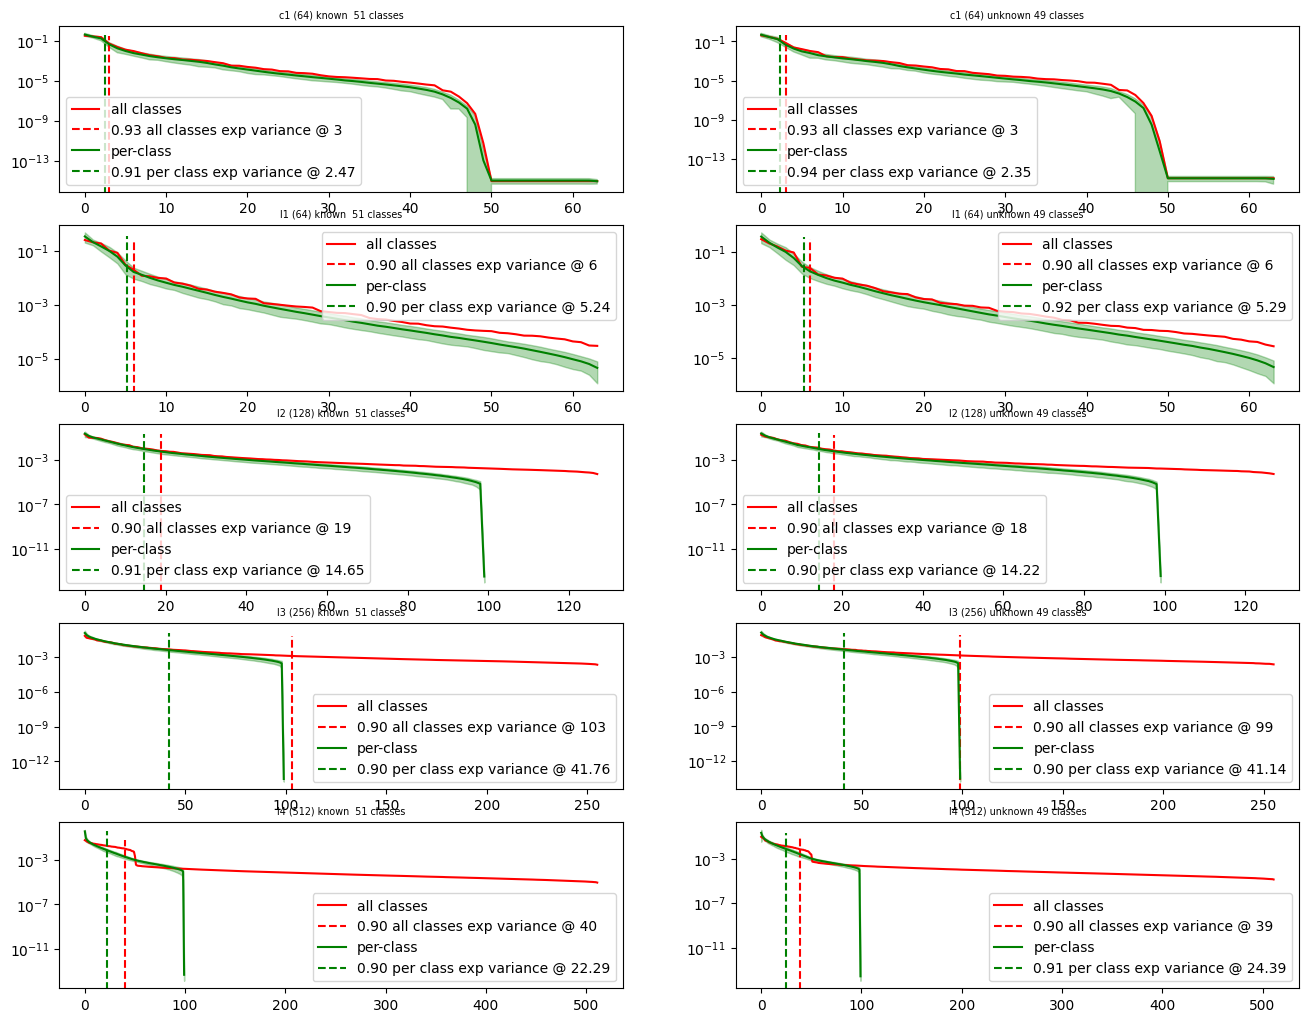

In [10]:
n_rows = len([k for k, fts in activations_1.items() if len(fts.shape) != 1 and k not in ["pool", "out"]])

n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 2.5*n_rows))


for a, acts in enumerate([activations_1, activations_2]):
    cr = 0

    for k, fts in acts.items():
        if k in ["pool", "out"] or len(fts.shape) == 1:
            continue

        pca = PCA().fit(fts)
        exp_var =  pca.explained_variance_ratio_

        cum = np.cumsum(exp_var)
        for i, c in enumerate(cum):
            if c > 0.9:
                break

        # plt.figure(figsize=(4,2))



        ax[cr][a].plot(np.arange(len(exp_var)), exp_var, label="all classes", color="red")
        ax[cr][a].plot([i] * 100, np.linspace(0,exp_var.max(), 100), "--", color="red", label=f"{c:.2f} all classes exp variance @ {i}")
        
        ttl = f"{k} ({fts.shape[1]}) " + ("known " if a == 0 else "unknown") + f" {len(set(acts['y_true']))} classes"
        ax[cr][a].set_title(ttl, size="x-small")
        ax[cr][a].set_yscale("log")

        #########################
        per_class_cums = []
        per_class_cs = []

        for c in list(set(acts["y_true"])): # todo check all
            index = acts["y_true"]==c
            c_fts = fts[index]
            pca = PCA().fit(c_fts)
            exp_var =  pca.explained_variance_ratio_

            cum = np.cumsum(exp_var)
            for i, c in enumerate(cum):
                if c > 0.9:
                    break

            per_class_cums.append(exp_var)
            per_class_cs.append(i)

        pccm = np.mean(per_class_cums, axis=0)
        pccs = np.std(per_class_cums, axis=0) * 2

        # print(pccs[:5])

        ax[cr][a].plot(np.arange(len(pccm)), pccm, label="per-class", color="green")

        ax[cr][a].fill_between(np.arange(len(pccm)), pccm-pccs, pccm+pccs, alpha=0.3, color="green")

        cm = np.mean(per_class_cs)
        ax[cr][a].plot(
            [cm] * 100, 
            np.linspace(0,pccm.max(), 100), 
            "--", color="green", 
            label=f"{c:.2f} per class exp variance @ {cm:.2f}"
        )
        ax[cr][a].set_yscale("log")
        ax[cr][a].legend()
        cr+=1
    
plt.show()

* network collapses between ResBlock 3 and 4
* "effective rank" is smaller for particular classes than for all dataset
* effective ranks for known classes (left) are, in general, larger than tfor unknown classes (except for per-class in l4)

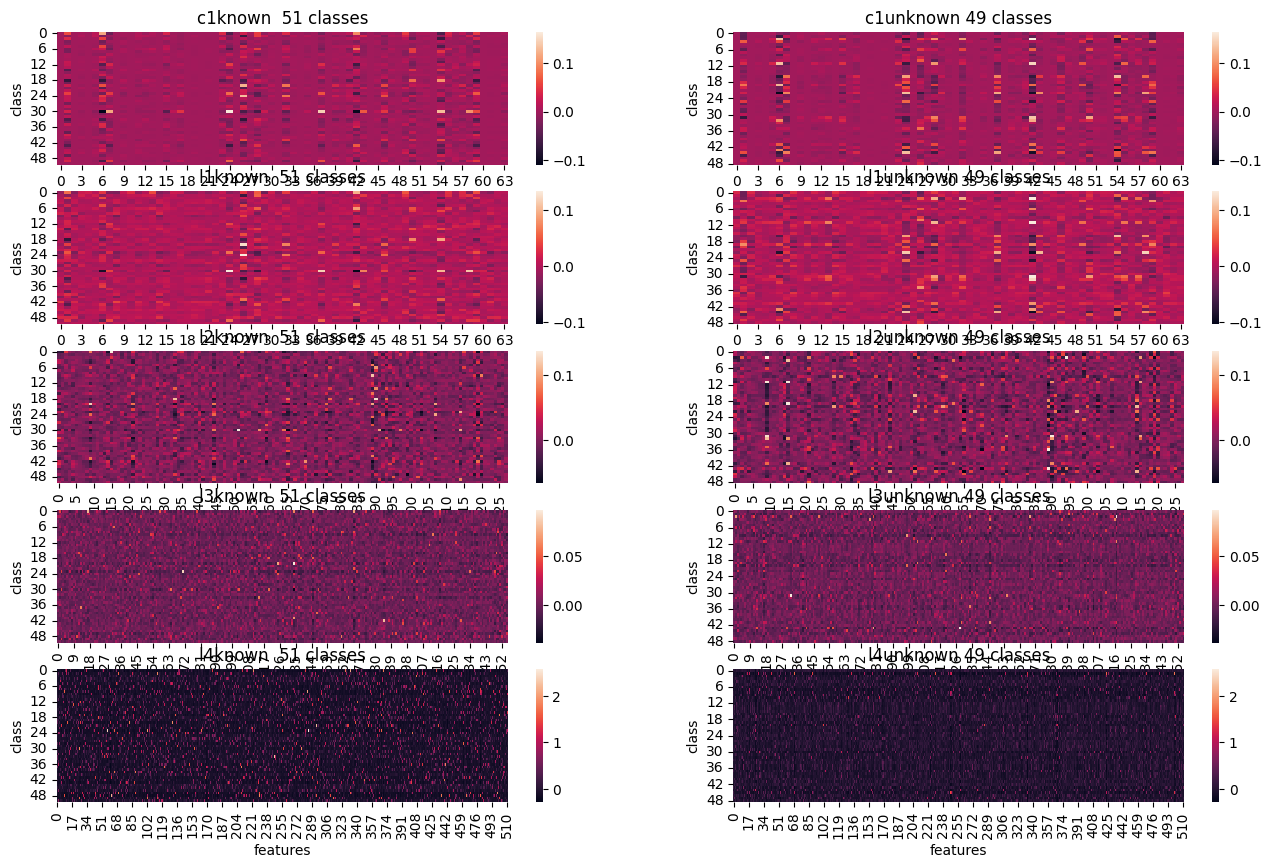

In [11]:
n_rows = len([k for k, fts in activations_1.items() if len(fts.shape) != 1 and k not in ["pool", "out"]])

n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 2*n_rows))

scales = dict()

for a, acts in enumerate([activations_1, activations_2]):
    cr = 0
    for k, fts in acts.items():
        if len(fts.shape) == 1 or k in ["pool", "out"]:
            continue

        per_class_acts = []

        mn = fts.mean(axis=0)

        # print(mn.shape)


        for c in sorted(list(set(acts["y_true"]))): # todo check all
            index = acts["y_true"]==c

            c_acts = fts[index]

            # print("c", c_acts.mean(axis=0).shape, mn.shape)

            per_class_acts.append(
                c_acts.mean(axis=0) - mn
            )

        mp = np.array(per_class_acts)
        if k not in scales:
            vmin, vmax = mp.min(), mp.max()
            scales[k] = dict(vmin=vmin, vmax=vmax)
        
        sns.heatmap(mp, ax=ax[cr][a], **scales[k])
        ax[cr][a].set_title(k +  ("known " if a == 0 else "unknown") + f" {len(set(acts['y_true']))} classes")
        ax[cr][a].set_ylabel("class")
        ax[cr][a].set_xlabel("features")
        
        cr +=1

plt.show()

(array([58., 78., 53., 33., 14.,  6.,  4.,  5.,  2.,  3.]),
 array([0.00043006, 0.00980707, 0.01918408, 0.02856109, 0.0379381 ,
        0.04731511, 0.05669212, 0.06606913, 0.07544614, 0.08482315,
        0.09420016]),
 <BarContainer object of 10 artists>)

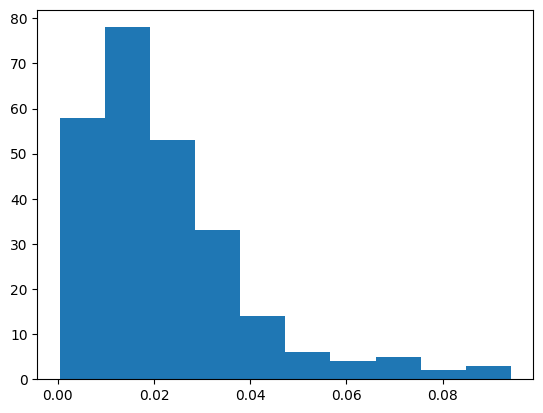

In [15]:
plt.hist(activations_1["l3"][0])

In [22]:
 np.exp(2), np.exp(4), np.exp(8),

(7.38905609893065, 54.598150033144236, 2980.9579870417283)

/tmp/ipykernel_3453908/555284059.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.hist(torch.nn.functional.softmax(torch.tensor(activations_1["l3"][0])).numpy())


(array([62., 79., 53., 29., 14.,  5.,  5.,  4.,  2.,  3.]),
 array([0.00382061, 0.00385816, 0.00389572, 0.00393328, 0.00397084,
        0.0040084 , 0.00404596, 0.00408352, 0.00412108, 0.00415864,
        0.0041962 ]),
 <BarContainer object of 10 artists>)

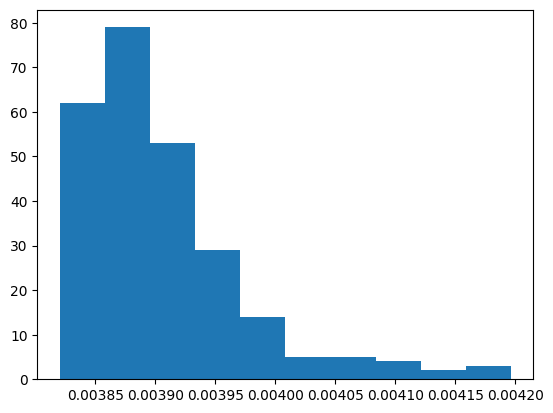

In [18]:
plt.hist(torch.nn.functional.softmax(torch.tensor(activations_1["l3"][0])).numpy())

TODO:
* train the remaining classes on top of the trained features (as a separate classifier head)
* produce the same charts for the second half of classes


Exploring ways for reducing collapse:
* reducing weight decay
* stop-gradient at residual connections 